# Text classification (multiclass) 

### Tutorial for beginners in text classification analysis using Python

__Data__: Consumer complaints received about financial products and services<br>
__Data source:__ Public dataset downloaded from 
https://catalog.data.gov/dataset/consumer-complaint-database
on 2019, May 13.

These are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, we used different machine learning algorithms can make more accurate predictions (i.e., classify the complaint in one of the product categories).

# Table of Content

* [Goal](#obj)
* [Importing packages and loading data](#imp)
* [Exploratory Data Analysis (EDA) and Feature Engineering](#eda)
* [Text Preprocessing](#pre)
* [Multi-Classification models](#ml)
    * [Spliting the data: train and test](#sp)
    * [Models](#m)
* [Comparison of model performance](#sum)
* [Model Evaluation](#ev)
    * [Precision, Recall, F1-score](#f1)
    * [Confusion Matrix](#cm)
* [Predictions](#pred)

<a id='obj'></a>
## Goal:<br>
Classify consumer complaints into predefined categories.<br><br>
Classification algorithms: Linear Support Vector Machine (LinearSVM), Random Forest, Multinomial Naive Bayes and Logistic Regression.<br><br>
Note: Text classification is an example of supervised machine learning since we train the model with labelled data (complaints about and specific finance product is used for train a classifier.

<a id='imp'></a>
## Importing packages and loading data

In [1]:
# Input data files are available in the "../input/" directory.
import os
# print(os.listdir("../input"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# loading data
df = pd.read_csv(r"complaints.csv")
df.shape

(4065103, 18)

We have more than 1 million instances (rows) and 18 features (columns).

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [3]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-09-04,2023-09-06
Product,"Money transfer, virtual currency, or money ser...",Debt collection
Sub-product,Mobile or digital wallet,Other debt
Issue,Trouble accessing funds in your mobile or digi...,Attempts to collect debt not owed
Sub-issue,NaN,Debt was result of identity theft
Consumer complaint narrative,NaN,NaN
Company public response,NaN,Company believes the complaint is the result o...
Company,"Paypal Holdings, Inc","CCS Financial Services, Inc."
State,NC,FL
ZIP code,27587,33032


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1472203, 2)

In [5]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

From more than 1 million complaints, there are about 380,000 cases with text (~ 30% of the original dataset is not null). This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [6]:
pd.DataFrame(df.Product.unique()).values

array([['Money transfer, virtual currency, or money service'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Credit reporting or other personal consumer reports'],
       ['Mortgage'],
       ['Credit card'],
       ['Vehicle loan or lease'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit card or prepaid card'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Bank account or service'],
       ['Payday loan, title loan, or personal loan'],
       ['Debt or credit management'],
       ['Credit reporting'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [7]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [9]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Checking or savings account
3,Credit card or prepaid card
4,Debt collection
5,"Money transfer, virtual currency, or money ser..."
6,"Payday loan, title loan, or personal loan"
7,Student loan
8,Consumer Loan
9,Vehicle loan or lease


The number of classes were reduced from 18 to 13. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [10]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
337270,"Credit reporting, repair, or other",The date of my first letter was XXXX. I sent a...,0
814826,"Credit reporting, repair, or other",I was XXXX and my ID and social security card ...,0
1157572,"Credit reporting, repair, or other",I'm really not sure what happened. I have mail...,0
589205,Mortgage,I was impacted by hurricane Irma and then Mich...,1
2863449,Checking or savings account,I am a XXXX XXXX XXXX by trade. \n\nAt the en...,2


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:
* credit reporting, credit repair
* debt collection 
* mortgage 

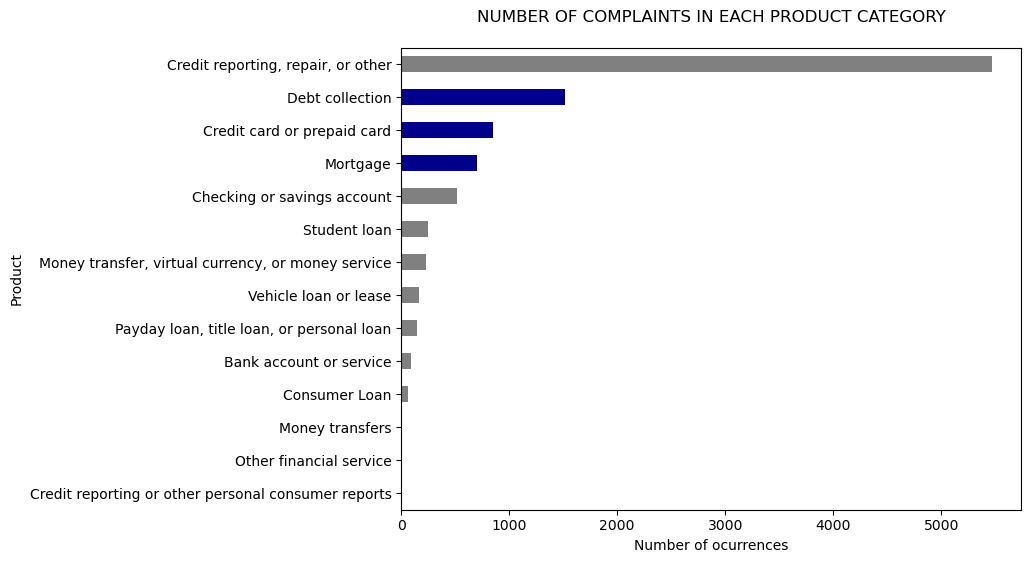

In [11]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26339 features (TF-IDF score of unigrams and bigrams)


In [14]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: cd, stocks, promotion
  * Most Correlated Bigrams are: checking account, xxxx 2015, posting xxxx

==> Checking or savings account:
  * Most Correlated Unigrams are: deposited, overdraft, bank
  * Most Correlated Bigrams are: overdraft fees, savings account, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: vehicle, car, motor
  * Most Correlated Bigrams are: title loan, chrysler capital, car car

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, amex, card
  * Most Correlated Bigrams are: use card, american express, credit card

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: usc, treat, 166b
  * Most Correlated Bigrams are: end consumer, late purpose, 166b creditor

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: consumer reporting, 15 1681, 1681 sect

<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [15]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [18]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    #LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\MSI\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\MSI\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\MSI\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\MSI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [19]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LogisticRegression,0.7970,0.004424
MultinomialNB,0.6469,0.003668
RandomForestClassifier,0.5465,0.000150


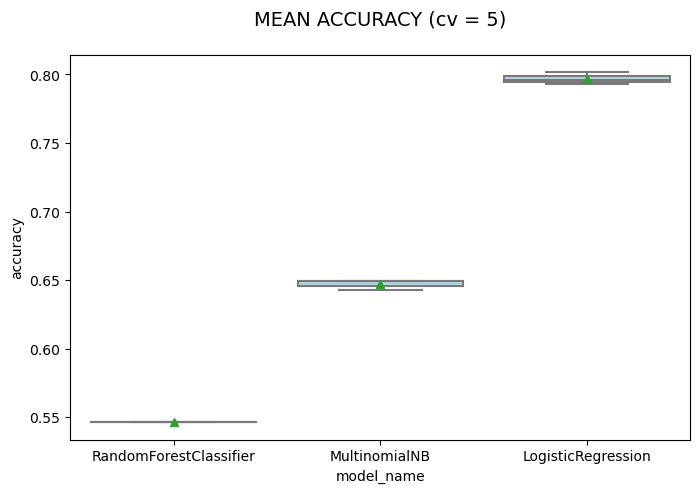

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [21]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

It is possible to observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data.<br><br>
The classes that can be classified with more precision are __‘Mortgage’__, __‘Credit reporting, repair, or other’__, and __‘Student loan’__.

<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

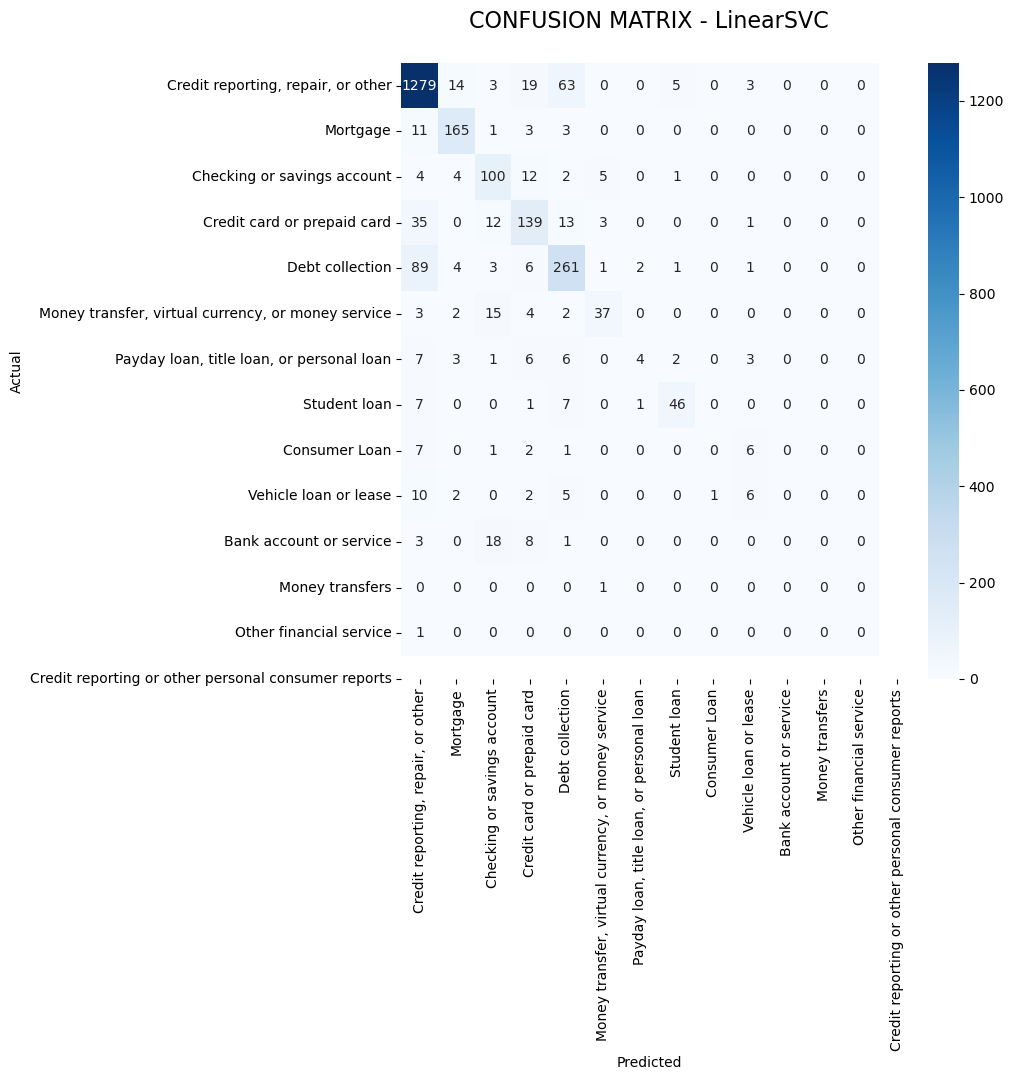

In [24]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [25]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 35 examples.


,Product,Consumer_complaint
1795848,Credit card or prepaid card,I have had several credit cards closed by issu...
471714,Credit card or prepaid card,I am XXXX XXXX XXXX and I am submitting this c...
1439608,Credit card or prepaid card,CHASE CARD MADE A HARD INQUIRE ON MY CREDIT RE...
2380553,Credit card or prepaid card,I checked my report on XX/XX/2021 and see this...
986201,Credit card or prepaid card,I have not received confirmation not certified...
1866351,Credit card or prepaid card,There are duplicate accounts reflected on all ...
811589,Credit card or prepaid card,"On XX/XX/XXXX, I called XXXX XXXX XXXX to inqu..."
532930,Credit card or prepaid card,XXXX card did a hard inquiry in my credit with...
1869638,Credit card or prepaid card,The following debit card transactions of withd...
3241057,Credit card or prepaid card,It is highly unjustifiable to have late paymen...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 89 examples.


,Product,Consumer_complaint
1332531,Debt collection,I have been disputing this account with Wells ...
3721812,Debt collection,I noticed these accounts reflecting on my cred...
2084414,Debt collection,I have contacted consumer adjustment company i...
1835001,Debt collection,I am the general executor and trustee of the X...
2337054,Debt collection,I have contacted this company through the cred...
...,...,...
804289,Debt collection,On XX/XX/2018 notice XXXX XXXX balance of {$26...
3509657,Debt collection,This dept is not mine and its. Makeing my life...
3313205,Debt collection,im receving bills from Lowes for someone named...
1478356,Debt collection,THIS INFORMATION IS INCORRECT IN MORE THAN ONE...


IndexError: index 13 is out of bounds for axis 0 with size 13

#### Most correlated terms with each category

In [27]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: bank, promotion, branch, 2016
  * Top bigrams: xxxx 2015, xx 2016, bank did, checking account

==> 'Checking or savings account':
  * Top unigrams: bank, savings, chime, checking
  * Top bigrams: debit card, savings account, 36 00, overdraft fees

==> 'Consumer Loan':
  * Top unigrams: car, motor, vehicle, acceptance
  * Top bigrams: xxxx 16, report owe, going pay, auto xxxx

==> 'Credit card or prepaid card':
  * Top unigrams: card, amex, purchase, capital
  * Top bigrams: american express, pay balance, missed payment, care credit

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: 166b, usc, 604, purpose
  * Top bigrams: 166b creditor, 15 usc, xxxx violated, late purpose

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, inquiries
  * Top bigrams: victim identity, xxxx xxxx, experian xxxx, late payments

==> 'Debt collection':
  * Top unigrams: debt, recovery, collecti

<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

In [29]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

In [30]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id


Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [31]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [32]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id


Again, the algorithm correctly classified the caomplaint as __"Credit reporting, repair, or other"__. Note that this customer has used terms with high TFIDF score, such us __equifax, report__. <br><br>
Although our model is not going to be all the time correct when classifying new complaints, it does a good job.